In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# 12345->01234
# delete 4, delete 1, 23->1
label = np.load("Cas.npy")
label = label.reshape(4989,1)
label = label - 1

index = np.where(label==4)
label = np.delete(label, np.where(label == 4))

index_0 = np.where(label==0)
index_0 = index_0[0][:2800]
label = np.delete(label, index_0)

index_1 = np.where(label==1)
label = np.delete(label, index_1)

label[label==2] = 1
label[label==3] = 1

label = label.reshape(1491, 1)

In [4]:
for i in range(4):
    print(f"The number of images with label {i} is {np.where(label ==i)[0].shape}")

The number of images with label 0 is (780,)
The number of images with label 1 is (711,)
The number of images with label 2 is (0,)
The number of images with label 3 is (0,)


In [5]:
RESIZED_ROOT = os.path.join(os.path.dirname(os.path.abspath('')),'Classifier','files_choose')
path_list = os.listdir(RESIZED_ROOT)
path_list.sort(key = lambda x:int(x.split('.')[0]))

file = []
for file_name in path_list:
    file.append(file_name)

file = np.array(file)
file = np.delete(file, index)
file = np.delete(file, index_0)
file = np.delete(file, index_1)
file = file.reshape(1491,1)

annotation = np.concatenate((file,label),axis=1)
annotation.shape



(1491, 2)

In [6]:
from sklearn.model_selection import train_test_split
X = file
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train, y_train
annotation_train = np.concatenate((X_train,y_train),axis=1)
annotation_test = np.concatenate((X_test,y_test),axis=1)
(annotation_train.shape, annotation_test.shape)

((998, 2), (493, 2))

In [8]:
def get_norm_para(img):
    Mean = []
    Std = []
    for i in range(3):
        mean = np.mean(np.array(img[i]))
        Mean.append(mean)
        std = np.std(np.array(img[i]))
        Std.append(std)
    return Mean, Std

In [9]:
def Normalization(img):
    img = np.array(img)
    img = img.astype(np.float32)
    for i in range(3):
        minValue = np.min(img[i])
        maxValue = np.max(img[i])
        ecart = maxValue - minValue
        img[i] = (img[i] - minValue) / ecart
    img = torch.tensor(img)
    return img

In [10]:
# img = read_image('/workspace/Classifier/files_choose/1104.jpg')
# print(img)
# img = Normalization(img)
# print(img)

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.to(torch.float)
        image = Normalization(image)
        label = self.img_labels.iloc[idx, 1]
        label = int(label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
# AllSet = CustomImageDataset(annotation,"files_resized_choose")
# AllSet.img_labels
# image, label = AllSet.__getitem__(1)

In [13]:
transform = transforms.Compose(
    [transforms.Resize((960,960), antialias=True)])

In [14]:
training_data = CustomImageDataset(annotation_train,"files_choose",transform=transform)
test_data = CustomImageDataset(annotation_test,"files_choose",transform=transform)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

Feature batch shape: torch.Size([32, 3, 960, 960])
Labels batch shape: torch.Size([32])


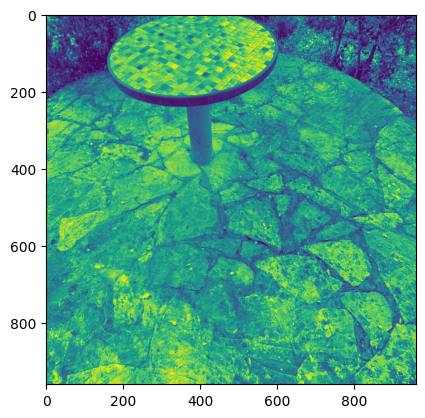

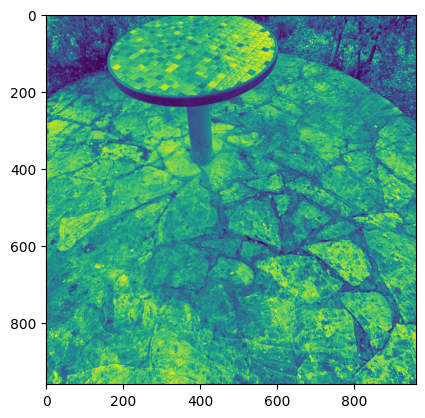

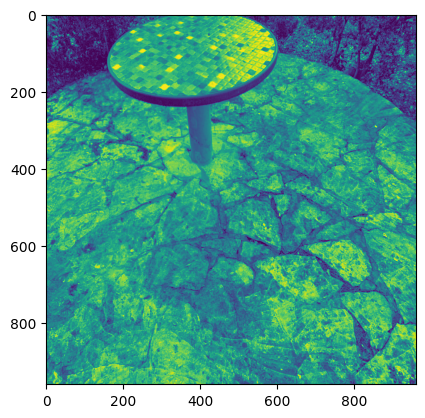

Label: 0


In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(3):
    img = train_features[0][i]
    plt.imshow(img)
    plt.show()
label = train_labels[0]
print(f"Label: {label}")

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 48, 3)
        self.conv4 = nn.Conv2d(48, 16, 3)
        self.conv5 = nn.Conv2d(16, 6, 3)
        self.conv6 = nn.Conv2d(6, 3, 3)
        self.fc1 = nn.Linear(507, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=507, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [18]:
len(train_dataloader)

32

In [19]:
train_loss = []
test_loss = []

In [20]:
for epoch in range(50):  

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()               
    print(f'epoch:{epoch+1} loss:{running_loss / len(train_dataloader)}')
    train_loss.append(running_loss / len(train_dataloader))
    
# Validation of test set
    loss_test = 0
    with torch.no_grad():
        for data in test_dataloader:
            images = data[0].to(device)
            labels = data[1].to(device)
            output = net(images)
            loss = criterion(output, labels)
            loss_test += loss.item()
    test_loss.append(loss_test / len(test_dataloader))

print('Finished Training')

epoch:1 loss:0.6943582259118557
epoch:2 loss:0.6941067799925804
epoch:3 loss:0.6938750669360161
epoch:4 loss:0.6943276729434729
epoch:5 loss:0.6939366180449724
epoch:6 loss:0.6938743405044079
epoch:7 loss:0.6941043380647898
epoch:8 loss:0.6940213851630688
epoch:9 loss:0.6937225442379713
epoch:10 loss:0.6937767509371042
epoch:11 loss:0.6939258873462677
epoch:12 loss:0.6938282065093517
epoch:13 loss:0.6935128029435873
epoch:14 loss:0.6934717763215303
epoch:15 loss:0.6936242673546076
epoch:16 loss:0.6934987623244524
epoch:17 loss:0.6934300065040588
epoch:18 loss:0.6933177076280117
epoch:19 loss:0.6933307498693466
epoch:20 loss:0.693240974098444
epoch:21 loss:0.6932079140096903
epoch:22 loss:0.6932248137891293
epoch:23 loss:0.6931648496538401
epoch:24 loss:0.6931543797254562
epoch:25 loss:0.6931370459496975
epoch:26 loss:0.6930953282862902
epoch:27 loss:0.6930685341358185
epoch:28 loss:0.693067254498601
epoch:29 loss:0.6930864807218313
epoch:30 loss:0.6929991468787193
epoch:31 loss:0.69305

<function matplotlib.pyplot.show(close=None, block=None)>

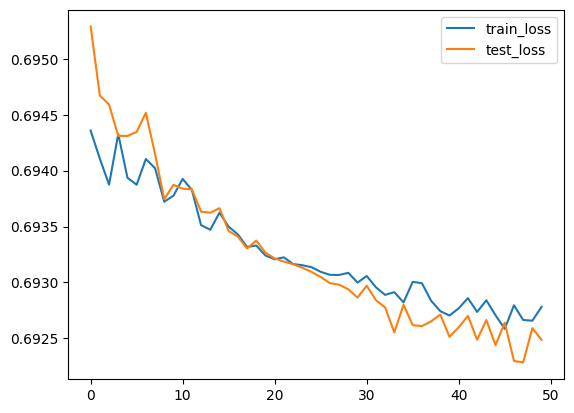

In [21]:
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.show

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy of the network on the train images:52.104208416833664%
Number of train images: 998


In [23]:
classes =('0','1')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images = data[0].to(device)
        labels = data[1].to(device)
        images = images.to(torch.float)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(f'Accuracy of the network on the test images:{100 * correct / total}%')
print('Number of train images:',total)

Accuracy for class: 0     is 100.0 %
Accuracy for class: 1     is 0.0 %
Accuracy of the network on the test images:52.73833671399594%
Number of train images: 493


In [24]:
PATH = './classification.pth'
torch.save(net.state_dict(), PATH)